In [215]:
import pylab
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage.interpolation import geometric_transform
global fps
fps = 20.

global origin
global origin_init
global v0,v1,h0,h1

origin_init = (312,220) ## approximate centroid of video frame
origin = origin_init ## to be updated later

In [4]:
train_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.mp4'
labels_file = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.txt'

In [10]:
## Parse labels file
file = open(labels_file, 'r') 
labels = file.read().split()
file.close()
labels = np.asarray(labels).astype('float32')

Text(0, 0.5, 'car speed (mph)')

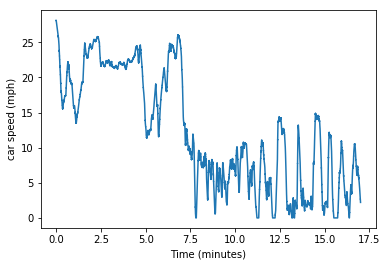

In [107]:
## Plot the training set speeds
t_plot = np.arange(0,len(labels),1)/fps
plt.plot(t_plot/60,labels)
#plt.plot(labels)
plt.xlabel('Time (minutes)')
plt.ylabel('car speed (mph)')

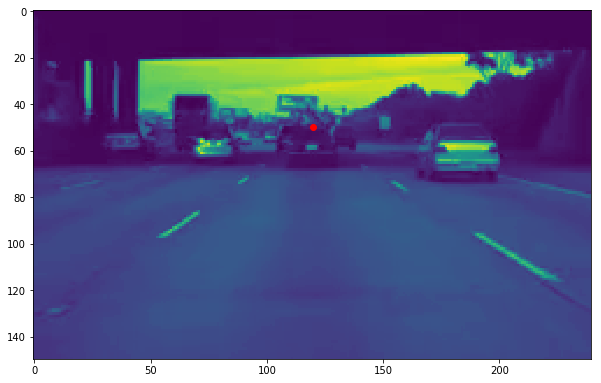

In [216]:
## Try loading a few fraes and mark the origin
vid = imageio.get_reader(train_vid,  'ffmpeg')
nums = range(100)
vid_frames = []
image = vid.get_data(0)
#print(image.shape[0])

v0 = origin_init[0] - 120
v1 = origin_init[0] + 120
h0 = origin_init[1] - 50
h1 = origin_init[1] + 100
origin = (120,50)

for num in nums:
    image = vid.get_data(num)
    vid_frames.append(image[h0:h1,v0:v1])

plt.figure(figsize = (10,10))
plt.imshow(vid_frames[0][:,:,1])

plt.plot(origin[0],origin[1],'ro')

## Get the video dimensions
v = vid_frames[0].shape[0]
h = vid_frames[0].shape[1]
#print(v)

## Manual test for speed based on number of frames to pass a white road line (10 feet)

Time to move 10 feet = 0.15 sec
Estimated speed = 45.45 mph
Claimed speed = 27.37 mph


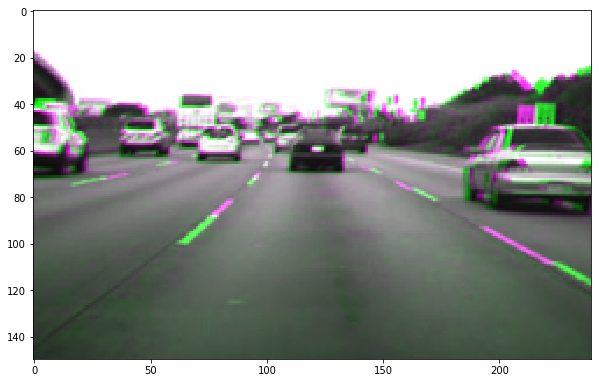

In [223]:
## Test to make sure speeds make sense - do a crude speed estimation
## a white line is 10 feet.
frame1 = 50
frame_diff = 3
V1 = [vid_frames[frame1][:,:,1]]
V1.append(vid_frames[frame1+frame_diff][:,:,1])
V1.append(vid_frames[frame1][:,:,1])
V2 = np.asarray(V1).transpose(1,2,0)
plt.figure(figsize = (10,10))
plt.imshow(V2)

## Note: it looks like the car moves 10 feet in about 3 frames
## Calculate miles per hour (split by lines to make it easy to check)
t_10ft = frame_diff/fps ## Time to move 10 feet = 3 frames / (20 frames/sec)
feet_per_mile = 5280.
dist_moved_miles = 10./feet_per_mile ## 10 f / (5280 ft/mile)
time_in_hours = t_10ft/3600. # time (sec) / (60 sec/min * 60 min/hr)
speed = dist_moved_miles/time_in_hours

print('Time to move 10 feet = %.2f sec' %t_10ft)
print('Estimated speed = %.2f mph' %speed)
print('Claimed speed = %.2f mph' %(labels[frame1]))

## Load in video while splitting into train and dev set with 5 sec intervals

In [219]:
np.random.seed(2)
def split_Nsec_intervals(vid_frames, labels, Nsec, maxFrames = None):
    ## Select random sets of n sec: 80% train set, 20% dev set
    
    vid = imageio.get_reader(train_vid,  'ffmpeg')
    
    if maxFrames == None:
        maxFrames = len(labels)
    
    Nframes = int(Nsec*fps)
    L = maxFrames
    L = L-np.mod(L,Nframes)
    i_split = np.random.rand(int(L/Nframes)) 
    A = np.percentile(i_split,80)
    i_split = i_split < A

    
    vidframes_train = []
    vidframes_dev = []
    labels_train = []
    labels_dev = []
    t_train = []
    t_dev = []
    
    for i,ix in enumerate(i_split):
        ind_frames = np.arange(i*Nframes,(i+1)*Nframes,1)
        if ix:
            for fr in ind_frames:
                image = vid.get_data(fr)
                vidframes_train.append(image[h0:h1,v0:v1])
        
            labels_train.append(labels[ind_frames])
            t_train.append(ind_frames/fps)
        else:
            for fr in ind_frames:
                image = vid.get_data(fr)
                vidframes_dev.append(image[50:450,50:600])
            labels_dev.append(labels[ind_frames])
            t_dev.append(ind_frames/fps)
            
    labels_train = np.asarray(labels_train).astype('float32').ravel()
    labels_dev = np.asarray(labels_dev).astype('float32').ravel()
    t_train = np.asarray(t_train).astype('float32').ravel()
    t_dev = np.asarray(t_dev).astype('float32').ravel()
    return vidframes_train,vidframes_dev,labels_train,labels_dev,t_train,t_dev

vidframes_train,vidframes_dev,labels_train,labels_dev,t_train,t_dev = split_Nsec_intervals(vid_frames,labels,Nsec = 5, maxFrames = 2000)
print('Training triplets: %d  Dev triplets: %d'%(len(vidframes_train),len(vidframes_dev)))
print('Training labels: %d  Dev labels: %d'%(len(labels_train),len(labels_dev)))

Training triplets: 1600  Dev triplets: 400
Training labels: 1600  Dev labels: 400


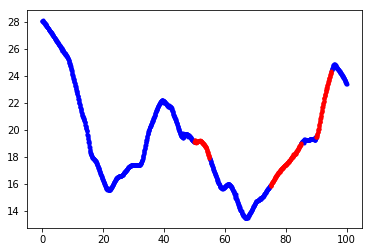

In [220]:
## Visualise speeds in the training and dev sets
plt.figure()
plt.plot(t_train,labels_train,'b.')
plt.plot(t_dev,labels_dev,'r.')

In [222]:
## Borrowed code to augment the training data by adjusting brightness
def brightness_augment(image, offset, rand_amplitude):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB), offset, and amplidute of the random variable
    returns: image with brightness augmentation
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = offset + rand_amplitude*np.random.uniform()
    hsv_image[:,:,2] = hsv_image[:,:,2] * factor
    im = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    im = np.round(255.*im/np.max(im)) ## Rescale to min/max of dataset
    return im.astype('uint8')

In [263]:
## More standard code - computes optical flow based on the Farneback method - 
## modified to avoid converting back to rgb
def opticalFlowFarneback_v2(image_current, image_next,win_size = 5):
    """
    input: image_current, image_next (greyscale_images)
    
    calculates optical flow magnitude and angle and places it into new image
    * Set axis 1 to actual image_next
    * Set axis 0 angles returned from computing the flow params
    * set axis 2 the magnitude returned from computing the flow params
    """        
    flow_im = np.zeros((fr0.shape[0],fr0.shape[1],2))
   # flow_im[:,:,0] = image_current
    
    # Flow Parameters
    #flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(image_current, image_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # direction
    flow_im[:,:,0] =  ang* (180/ np.pi / 2) #cv2.normalize(ang,None,0,255,cv2.NORM_MINMAX) #ang* (180/ np.pi / 2)
    
    # magnitude
    flow_im[:,:,1] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to int32's
    flow_im = np.asarray(flow_im, dtype= np.float32)
    return flow_im.astype('uint8')

Compute optic flow (Farneback method) on pairs of frames, and apply same algorithm to compute acceleration. Code modified to include 3 frames instead of 2, which enables the acceleration computation

In [296]:
## Brightness_augment and process
im = 7*3
fr2 = brightness_augment(vidframes_train[im+2],1,0)# 0.5,0.5)
fr1 = brightness_augment(vidframes_train[im+1],1,0)#,0.5,0.5)
fr0 = brightness_augment(vidframes_train[im],1,0)#,0.5,0.5)

fr2 = cv2.cvtColor(fr2, cv2.COLOR_RGB2GRAY)
fr1 = cv2.cvtColor(fr1, cv2.COLOR_RGB2GRAY)
fr0 = cv2.cvtColor(fr0, cv2.COLOR_RGB2GRAY)


flow = opticalFlowFarneback_v2(fr1,fr2,win_size = 2)
flow2  = opticalFlowFarneback_v2(fr1,fr0,win_size = 2)
#acc2 = opticalFlowFarneback_v2(flow[:,:,1], flow2[:,:,1],win_size = 2)

acc = flow2-flow

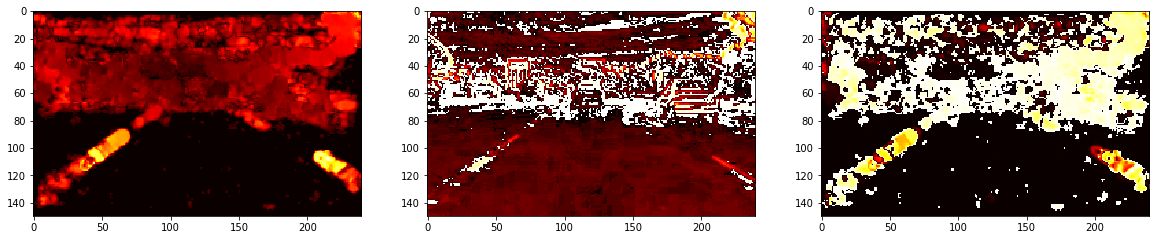

In [302]:
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.imshow(flow[:,:,1]**0.5,cmap = 'hot')
plt.subplot(132)
plt.imshow((fr1-fr2)**0.5,cmap = 'hot')#[:,:,2],cmap = 'gray')
plt.subplot(133)
plt.imshow(acc[:,:,1],cmap = 'hot')#[:,:,2],cmap = 'gray')

## Section 1a concatenate the data into training and dev sets

In [305]:
## Preproc data
vidframes_train_preproc = []
for im in range(len(vidframes_train_preproc)):
#        fr0 = brightness_augment(vidframes_train[im],1,0)
        fr0 = vidframes_train[im]
        fr0 = cv2.cvtColor(fr0, cv2.COLOR_RGB2GRAY)
        vidframes_train_preproc.append(fr0)


In [411]:
def create_set_for_model(vid_in):## Create array with the image, velocity and acc 
    triplet_array = []
    
    for im in range(int(len(vid_in)/3)):
        fr1 = brightness_augment(vid_in[im+2],0.5,0.5)
        fr0 = brightness_augment(vid_in[im+1],0.5,0.5)
        frm1 = brightness_augment(vid_in[im],0.5,0.5)

        flow, frgb = opticalFlowFarneback(fr0,fr1)
        flow2, frgb2 = opticalFlowFarneback(fr0,frm1)

        acc2,argb = opticalFlowFarneback(frgb, frgb2)
       # acc = flow2-flow

        input_vec = np.stack((flow[:,:,1],flow[:,:,2],flow[:,:,0],acc2[:,:,0],acc2[:,:,2]))
       # input_vec = np.stack((flow[:,:,1], acc2[:,:,0],acc2[:,:,2]))
            
        triplet_array.append(input_vec.T)

    return np.asarray(triplet_array)

train_array = create_set_for_model(vidframes_train)
dev_array = create_set_for_model(vidframes_dev)

In [412]:
print(train_array.shape)
print(np.asarray(labels_train).shape)
print(len(vidframes_train)/3)

(273, 550, 250, 5)
(273,)
273.0


## Section 2 - making the model

In [372]:
from keras.layers import Input, Dense,MaxPooling2D,Flatten, Conv2D,BatchNormalization,Activation
from keras.models import Model
## model from the course

def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
   # X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (2, 2), name = 'conv0')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((20, 20), name='max_pool')(X)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (5, 5), strides = (2, 2), name = 'conv1')(X_input)
    X = BatchNormalization(axis = -1, name = 'bn1')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((20, 20), name='max_pool1')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='SpeedModel')

    return model

In [373]:
#print(np.asarray(train_array).shape)
spModel = model(np.asarray(train_array[0]).shape)

In [374]:
spModel.compile(optimizer = 'adam', loss = "mean_squared_error", metrics = ['mse'])

In [396]:
history2step = spModel.fit(x = train_array, y = np.asarray(labels_train).astype('float32'), epochs = 3, batch_size = 16)


Epoch 1/3
273/273 [==============================] - 23s 84ms/step - loss: 8.6992 - mean_squared_error: 8.6992
Epoch 2/3
273/273 [==============================] - 23s 85ms/step - loss: 7.5115 - mean_squared_error: 7.5115
Epoch 3/3
273/273 [==============================] - 23s 84ms/step - loss: 6.6816 - mean_squared_error: 6.6816


In [397]:
history.model

In [398]:
preds = spModel.evaluate(x = dev_array, y = np.asarray(labels_dev).astype('float32'))

60/60 [==============================] - 2s 27ms/step


In [399]:
print(preds[1])

8.226538880666096


In [404]:
pred_speed_t = spModel.predict(x = train_array)
pred_speed_d = spModel.predict(x = dev_array)

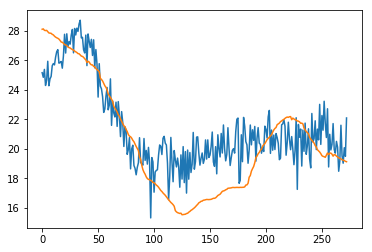

In [405]:
plt.plot(pred_speed_t)
plt.plot(np.asarray(labels_train).astype('float32'))

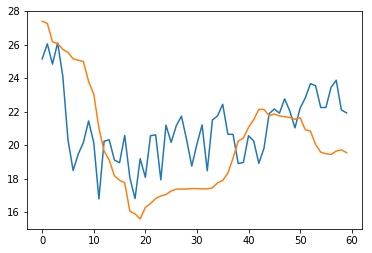

In [406]:
plt.plot(pred_speed_d)
plt.plot(np.asarray(labels_dev).astype('float32'))